# Nepal Trek Recommender Model

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import joblib

## 1. Data Loading and Preprocessing

In [79]:
# Load the trek data
df = pd.read_csv('nepal-treking-dataset\\Trek Data.csv')
print(f"Loaded {len(df)} trek records")
df.head()

Loaded 383 trek records


,Unnamed: 0,Trek,Cost,Time,Trip Grade,Max Altitude,Accomodation,Best Travel Time,Contact or Book your Trip
0,0,Everest Base Camp Trek,"\r\n$1,420 USD",16 Days,Moderate,5545 m,Hotel/Guesthouse,March - May & Sept - Dec,https://www.nepalhikingteam.com
1,1,Everest Base Camp Short Trek,"\r\n$1,295 USD",14 Days,Moderate,5545 m,Hotel/Guesthouse,March - May & Sept - Dec,https://www.nepalhikingteam.com
2,2,Everest Base Camp Heli Shuttle Trek,\r\n$2000 USD,12 Days,Moderate,5545 m,Hotel/Guesthouse,March - May & Sept - Dec,https://www.nepalhikingteam.com
3,3,Everest Base Camp Heli Trek,"\r\n$3,300 USD",11 Days,Moderate,5545 m,Hotel/Guesthouse,March - May & Sept - Dec,https://www.nepalhikingteam.com
4,4,Everest Base Camp Trek for Seniors,"\r\n$1,800 USD",20 Days,Moderate,5545 m,Hotel/Guesthouse,March - May & Sept - Dec,https://www.nepalhikingteam.com


In [80]:
# Basic preprocessing - drop unnamed column
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values[missing_values > 0])

# Drop any rows with missing values
df = df.dropna()
print(f"\nRemaining records after dropping missing values: {len(df)}")


Missing values per column:
Series([], dtype: int64)

Remaining records after dropping missing values: 383


In [81]:
# Convert cost, altitude and time to numerical values
def convert_cost(cost_str):
    cost_str = str(cost_str).lower()  # Ensure it's a string
    cost_str = cost_str.replace('$','').replace('usd','').strip()
    cost_str = cost_str.replace(',','')
    try:
        return float(cost_str)
    except ValueError:
        print(f"Warning: Could not convert cost: '{cost_str}'")
        return 0.0  # Default value

def convert_max_altitude(altitude_str):
    altitude_str = str(altitude_str).lower()  # Ensure it's a string
    altitude_str = altitude_str.replace('m', '').strip()
    altitude_str = altitude_str.replace(',', '')
    try:
        return int(altitude_str)
    except ValueError:
        print(f"Warning: Could not convert altitude: '{altitude_str}'")
        return 0  # Default value

def convert_days(day_str):
    day_str = str(day_str).lower()  # Ensure it's a string
    day_str = day_str.replace('days', '').replace('day', '').strip()
    try:
        return int(day_str)
    except ValueError:
        print(f"Warning: Could not convert days: '{day_str}'")
        return 0  # Default value

# Apply the conversions
df['Cost'] = df['Cost'].apply(convert_cost)
df['Max Altitude'] = df['Max Altitude'].apply(convert_max_altitude)
df['Time'] = df['Time'].apply(convert_days)

df.head()

,Trek,Cost,Time,Trip Grade,Max Altitude,Accomodation,Best Travel Time,Contact or Book your Trip
0,Everest Base Camp Trek,1420.0,16,Moderate,5545,Hotel/Guesthouse,March - May & Sept - Dec,https://www.nepalhikingteam.com
1,Everest Base Camp Short Trek,1295.0,14,Moderate,5545,Hotel/Guesthouse,March - May & Sept - Dec,https://www.nepalhikingteam.com
2,Everest Base Camp Heli Shuttle Trek,2000.0,12,Moderate,5545,Hotel/Guesthouse,March - May & Sept - Dec,https://www.nepalhikingteam.com
3,Everest Base Camp Heli Trek,3300.0,11,Moderate,5545,Hotel/Guesthouse,March - May & Sept - Dec,https://www.nepalhikingteam.com
4,Everest Base Camp Trek for Seniors,1800.0,20,Moderate,5545,Hotel/Guesthouse,March - May & Sept - Dec,https://www.nepalhikingteam.com


## 2. Feature Engineering

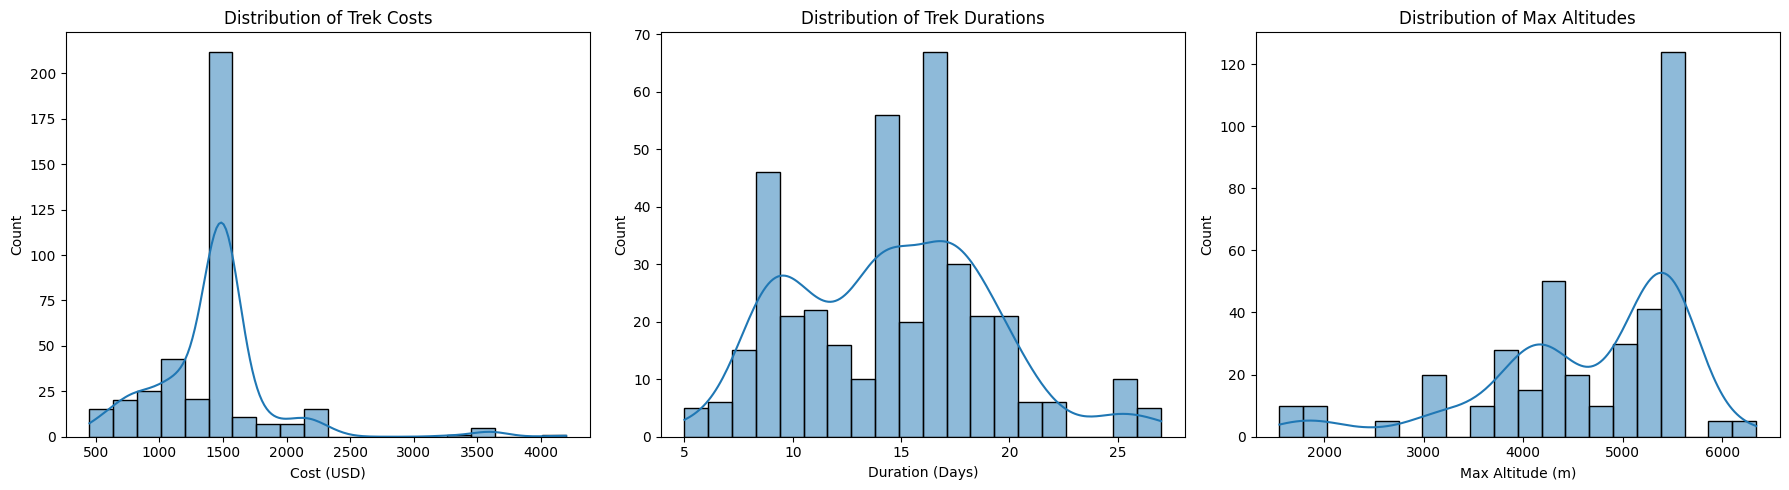

In [82]:
# Create better categories with more appropriate bins
# Analyze the distributions first to set better bin ranges
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Cost distribution
sns.histplot(df['Cost'], bins=20, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Trek Costs')
axes[0].set_xlabel('Cost (USD)')

# Duration distribution
sns.histplot(df['Time'], bins=20, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Trek Durations')
axes[1].set_xlabel('Duration (Days)')

# Altitude distribution
sns.histplot(df['Max Altitude'], bins=20, kde=True, ax=axes[2])
axes[2].set_title('Distribution of Max Altitudes')
axes[2].set_xlabel('Max Altitude (m)')

plt.tight_layout()
plt.show()

In [83]:
# Create difficulty mapping - standardize trip grades
unique_grades = df['Trip Grade'].unique()
print("Unique trip grades:")
print(unique_grades)

# Create a mapping for difficulty based on the trip grades
difficulty_mapping = {}

for grade in unique_grades:
    grade_lower = grade.lower()
    if any(easy in grade_lower for easy in ['easy', 'beginner']):
        difficulty_mapping[grade] = 'Easy'
    elif any(moderate in grade_lower for moderate in ['moderate', 'intermediate']):
        difficulty_mapping[grade] = 'Moderate'
    elif any(difficult in grade_lower for difficult in ['difficult', 'advanced', 'challenging', 'hard']):
        difficulty_mapping[grade] = 'Difficult'
    else:
        difficulty_mapping[grade] = 'Moderate'  # Default to moderate

# Apply the mapping
df['Difficulty'] = df['Trip Grade'].map(difficulty_mapping)

# Check the distribution
print("\nDifficulty distribution:")
print(df['Difficulty'].value_counts())

Unique trip grades:
['Moderate' 'Strenuous' 'Easy To Moderate' 'Easy' 'Moderate+Demanding'
 'Demanding' 'Light+Moderate' 'Demanding+Challenging' 'Light'
 'Moderate-Hard' 'Easy-Moderate']

Difficulty distribution:
Difficulty
Moderate     270
Easy          93
Difficult     20
Name: count, dtype: int64


In [84]:
# Create cost range categories
def categorize_cost(cost):
    if cost < 1000:
        return "Low"
    elif cost < 2000:
        return "Medium"
    elif cost < 3000:
        return "High"
    else:
        return "Very High"

# Create duration categories
def categorize_duration(days):
    if days <= 5:
        return "Short"
    elif days <= 10:
        return "Medium"
    elif days <= 15:
        return "Long"
    else:
        return "Very Long"

# Create altitude categories
def categorize_altitude(altitude):
    if altitude < 3000:
        return "Low"
    elif altitude < 4000:
        return "Moderate"
    elif altitude < 5000:
        return "High"
    else:
        return "Very High"

# Apply the categorization functions
df['Cost Range'] = df['Cost'].apply(categorize_cost)
df['Duration Category'] = df['Time'].apply(categorize_duration)
df['Altitude Category'] = df['Max Altitude'].apply(categorize_altitude)

# Check if Best Travel Time column exists, if not create a default one
if 'Best Travel Time' not in df.columns:
    # Check if Season column exists to extract from
    if 'Season' in df.columns:
        df['Best Travel Time'] = df['Season']
    else:
        # Default to the most popular trekking seasons in Nepal
        df['Best Travel Time'] = "Spring/Autumn"

# Create enhanced features column with improved formatting
df['Features'] = df.apply(
    lambda x: f"{x['Cost Range']} {x['Duration Category']} {x['Altitude Category']} {x['Difficulty']} {x['Best Travel Time']}",
    axis=1
)

print("Sample feature strings:")
for i in range(5):
    print(f"{i+1}. {df['Features'].iloc[i]}")

Sample feature strings:
1. Medium Very Long Very High Moderate March - May & Sept - Dec
2. Medium Long Very High Moderate March - May & Sept - Dec
3. High Long Very High Moderate March - May & Sept - Dec
4. Very High Long Very High Moderate March - May & Sept - Dec
5. Medium Very Long Very High Moderate March - May & Sept - Dec


In [85]:
df.head()

,Trek,Cost,Time,Trip Grade,Max Altitude,Accomodation,Best Travel Time,Contact or Book your Trip,Difficulty,Cost Range,Duration Category,Altitude Category,Features
0,Everest Base Camp Trek,1420.0,16,Moderate,5545,Hotel/Guesthouse,March - May & Sept - Dec,https://www.nepalhikingteam.com,Moderate,Medium,Very Long,Very High,Medium Very Long Very High Moderate March - Ma...
1,Everest Base Camp Short Trek,1295.0,14,Moderate,5545,Hotel/Guesthouse,March - May & Sept - Dec,https://www.nepalhikingteam.com,Moderate,Medium,Long,Very High,Medium Long Very High Moderate March - May & S...
2,Everest Base Camp Heli Shuttle Trek,2000.0,12,Moderate,5545,Hotel/Guesthouse,March - May & Sept - Dec,https://www.nepalhikingteam.com,Moderate,High,Long,Very High,High Long Very High Moderate March - May & Sep...
3,Everest Base Camp Heli Trek,3300.0,11,Moderate,5545,Hotel/Guesthouse,March - May & Sept - Dec,https://www.nepalhikingteam.com,Moderate,Very High,Long,Very High,Very High Long Very High Moderate March - May ...
4,Everest Base Camp Trek for Seniors,1800.0,20,Moderate,5545,Hotel/Guesthouse,March - May & Sept - Dec,https://www.nepalhikingteam.com,Moderate,Medium,Very Long,Very High,Medium Very Long Very High Moderate March - Ma...


In [86]:
# Save the enhanced data for the app
df.to_csv('nepal-treking-dataset\\Trek Data Modified.csv', index=False)

## 3. Model Training

In [87]:
vectorizer = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 2),  # Include both unigrams and bigrams
    min_df=2,           # Ignore terms that appear in less than 2 documents
    max_df=0.9,         # Ignore terms that appear in more than 90% of documents
    sublinear_tf=True   # Apply sublinear tf scaling (logarithmic)
)

# Fit and transform the features
X = vectorizer.fit_transform(df['Features'])
print(f"Feature matrix shape: {X.shape}")
print(f"Number of features: {len(vectorizer.get_feature_names_out())}")

Feature matrix shape: (383, 51)
Number of features: 51


In [88]:
# Train an KNN model
knn = NearestNeighbors(
    n_neighbors=min(10, len(df)),  # Start with more neighbors
    algorithm='auto',              # Let the algorithm choose the best approach
    metric='cosine',               # Cosine similarity is good for text features
    n_jobs=-1                      # Use all available cores
)

# Fit the model
knn.fit(X)

# Test the model with some examples
test_queries = [
    "Low Short Low Easy Spring",
    "High Long Very High Difficult Autumn",
    "Medium Medium Moderate Moderate Spring"
]

print("\nTesting the model with example queries:")
for query in test_queries:
    print(f"\nQuery: {query}")
    query_vector = vectorizer.transform([query])
    distances, indices = knn.kneighbors(query_vector, n_neighbors=3)
    
    print("Top 3 recommendations:")
    for i, (idx, dist) in enumerate(zip(indices[0], distances[0])):
        print(f"{i+1}. {df['Trek'].iloc[idx]} - Similarity: {1-dist:.2f}")


Testing the model with example queries:

Query: Low Short Low Easy Spring
Top 3 recommendations:
1. Short Annapurna Trek - Similarity: 0.94
2. Short Annapurna Trek - Similarity: 0.94
3. Short Annapurna Trek - Similarity: 0.94

Query: High Long Very High Difficult Autumn
Top 3 recommendations:
1. Everest Base Camp Heli Trek - Similarity: 0.62
2. Luxury Everest Base Camp Heli Trek - Similarity: 0.62
3. Everest Base Camp Heli Shuttle Trek - Similarity: 0.61

Query: Medium Medium Moderate Moderate Spring
Top 3 recommendations:
1. Mardi Himal Trek   - Similarity: 0.91
2. Mardi Himal Trek   - Similarity: 0.91
3. Mardi Himal Trek   - Similarity: 0.91


## 4. Create Feature Mappings for the App

In [89]:
# Create feature mappings for the app
feature_mappings = {
    "cost_mapping": {
        "Low": "Budget",
        "Medium": "Standard",
        "High": "Premium",
        "Very High": "Luxury"
    },
    "duration_mapping": {
        "Short": "1-5 days",
        "Medium": "6-10 days",
        "Long": "11-15 days",
        "Very Long": "15+ days"
    },
    "altitude_mapping": {
        "Low": "Below 3000m",
        "Moderate": "3000-4000m",
        "High": "4000-5000m",
        "Very High": "Above 5000m"
    },
    "difficulty_mapping": {
        "Easy": ["Easy", "Beginner", "Simple"],
        "Moderate": ["Moderate", "Intermediate", "Medium"],
        "Difficult": ["Difficult", "Advanced", "Challenging", "Hard"]
    }
}

# Save feature mappings to JSON
with open('feature_mappings.json', 'w') as f:
    json.dump(feature_mappings, f, indent=4)
    
print("Feature mappings saved to feature_mappings.json")

Feature mappings saved to feature_mappings.json


In [90]:
# Save the model and vectorizer
joblib.dump(knn, 'knn_model.joblib')
joblib.dump(vectorizer, 'vectorizer.joblib')

print("Model and vectorizer saved successfully")

# Add this right after saving the model and vectorizer
def verify_model_files():
    print("\n--- Verifying saved model files ---")
    
    # Verify vectorizer
    loaded_vectorizer = joblib.load('vectorizer.joblib')
    
    # Check for required attributes
    required_attrs = ['vocabulary_', 'idf_', 'stop_words_']
    for attr in required_attrs:
        if hasattr(loaded_vectorizer, attr):
            print(f"✓ Vectorizer has {attr}")
        else:
            print(f"✗ ERROR: Vectorizer missing {attr}")
    
    # Test transforming new text
    test_text = "Medium Long Moderate Difficult Spring"
    try:
        transformed = loaded_vectorizer.transform([test_text])
        print(f"✓ Vectorizer successfully transformed text. Shape: {transformed.shape}")
    except Exception as e:
        print(f"✗ ERROR: Vectorizer failed to transform text: {e}")
    
    # Verify KNN model
    loaded_knn = joblib.load('knn_model.joblib')
    print(f"✓ KNN model loaded. Algorithm: {loaded_knn.algorithm}")
    
    # Test inference
    try:
        text_vector = loaded_vectorizer.transform([test_text])
        distances, indices = loaded_knn.kneighbors(text_vector)
        print(f"✓ KNN model successfully made predictions")
    except Exception as e:
        print(f"✗ ERROR: KNN prediction failed: {e}")
    
    print("--- Verification complete ---")

# Run verification
verify_model_files()

# In case of vectorizer issues, explicitly save again with all attributes
print("\nReexporting vectorizer to ensure all attributes are saved...")
vectorizer = joblib.load('vectorizer.joblib')
if hasattr(vectorizer, 'vocabulary_'):
    # Add a dummy transform to ensure the vectorizer is fully initialized
    _ = vectorizer.transform(["Test to ensure vectorizer is fitted"])
    joblib.dump(vectorizer, 'vectorizer.joblib')
    print("Vectorizer re-exported successfully")
else:
    print("ERROR: Vectorizer still missing vocabulary - recreating from scratch")
    # Recreate and save the vectorizer from scratch
    new_vectorizer = TfidfVectorizer(
        analyzer='word',
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.9,
        sublinear_tf=True
    )
    X = new_vectorizer.fit_transform(df['Features'])
    joblib.dump(new_vectorizer, 'vectorizer.joblib')
    print("New vectorizer created and saved")

# Final verification check
print("\nFinal verification:")
final_vectorizer = joblib.load('vectorizer.joblib')
print(f"Vectorizer vocabulary size: {len(getattr(final_vectorizer, 'vocabulary_', {}))}")
test_text = "Medium Long Moderate Difficult Spring"
transformed = final_vectorizer.transform([test_text])
print(f"Test transformation shape: {transformed.shape}")

Model and vectorizer saved successfully

--- Verifying saved model files ---
✓ Vectorizer has vocabulary_
✓ Vectorizer has idf_
✓ Vectorizer has stop_words_
✓ Vectorizer successfully transformed text. Shape: (1, 51)
✓ KNN model loaded. Algorithm: auto
✓ KNN model successfully made predictions
--- Verification complete ---

Reexporting vectorizer to ensure all attributes are saved...
Vectorizer re-exported successfully

Final verification:
Vectorizer vocabulary size: 51
Test transformation shape: (1, 51)
